In [ ]:
from src import SQL_Executor, SQL_Queries, dpd_calc
import pandas as pd
import matplotlib.pyplot as plt

executor = SQL_Executor()
query = SQL_Queries().DPD()
transactions_df = executor.execute_query(query.transactions())
installments_df = executor.execute_query(query.installments())

In [ ]:
transactions_df = transactions_df.sort_values("transaction_date")
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])
transactions_df["first_month"] = transactions_df["transaction_date"].dt.to_period("M")
transactions_df = transactions_df.drop(columns=["transaction_date"])
transactions_df = transactions_df.groupby("user_id").first().reset_index()

In [3]:
dpd_df = transactions_df.merge(installments_df, how="left", on="transaction_id")
dpd_df = dpd_calc(dpd_df)
dpd_df["dpd90"] = (dpd_df["dpd"] >= 90).astype(int)
dpd_df = (
    dpd_df.groupby(["first_month", "user_id", "installment_number"])["dpd90"]
    .max()
    .reset_index()
)
dpd_df = dpd_df.groupby(["first_month", "installment_number"])["dpd90"].mean().reset_index()
dpd_df["dpd90_pct"] = dpd_df["dpd90"] * 100

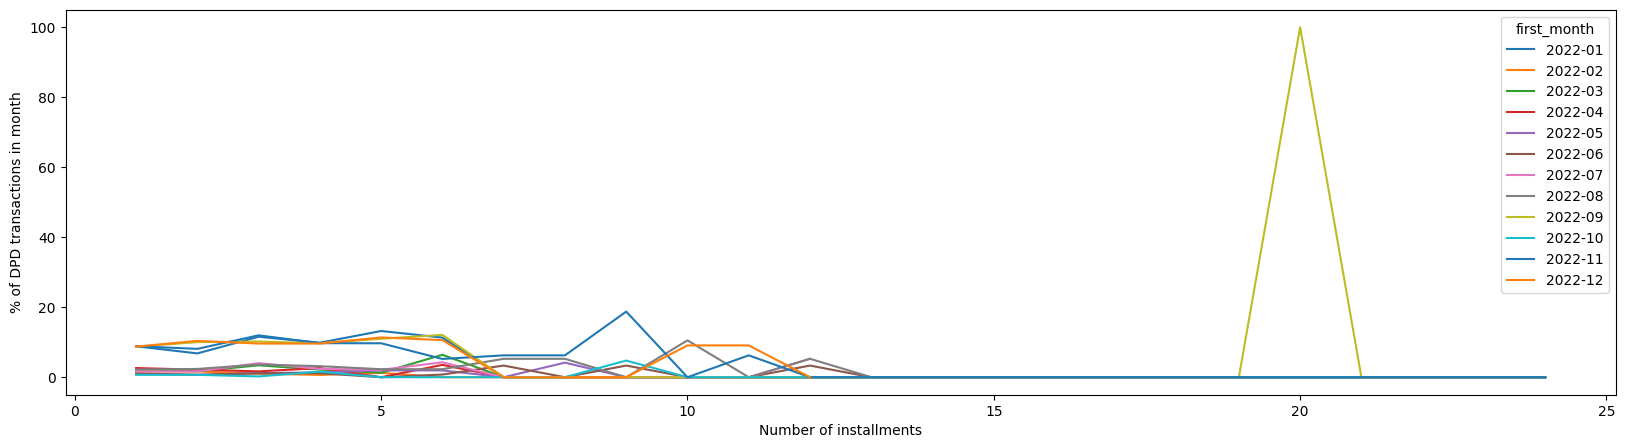

In [4]:
dpd_df = dpd_df[dpd_df["first_month"].astype(str).str[:4] == "2022"]

dpd_df.pivot(index="installment_number", columns="first_month", values="dpd90_pct").plot(
    kind="line", figsize=(20, 5)
)

plt.xlabel("Number of installments")
plt.ylabel("% of DPD transactions in month");